### Install Packages and Import Dataset

In this notebook, we’ll be working with a data set of 932 real estate transactions in Sacramento, California. This dataset contains several features regarding property details, including location, size, type, and price..

Each row in the dataset represents a listing, with various property details:

- **City:** The city where the property is located.
- **Zip:** The postal code for the property’s location.
- **Beds:** The number of bedrooms in the property.
- **Baths:** The number of bathrooms in the property.
- **Sqft:** The square footage of the property.
- **Type:** The type of property (e.g., Residential).
- **Latitude:** The latitude coordinate of the property.
- **Longitude:** The longitude coordinate of the property.

The target column is **Price**, which we will try to predict based on the other features in the dataset.

This dataset was obtained from [spatialkey](https://support.spatialkey.com/spatialkey-sample-csv-data/)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import set_config
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error


## Our question: **Can we use the size of a house in the Sacramento, CA area to predict its sale price?**

In [2]:
# Output dataframes instead of arrays
set_config(transform_output="pandas")

#set seed for reproducibility
np.random.seed(10)

sacramento = pd.read_csv("dataset/sacramento.csv")
sacramento

,street,city,zip,state,beds,baths,sq__ft,type,sale_date,price,latitude,longitude
0,1 KENNELFORD CIR,SACRAMENTO,95823,CA,3,2,1144,Residential,Mon May 19 00:00:00 EDT 2008,200345,38.464520,-121.427606
1,10 SEA FOAM CT,SACRAMENTO,95831,CA,3,3,2052,Residential,Wed May 21 00:00:00 EDT 2008,415000,38.487885,-121.545947
2,100 CHELSEA CT,FOLSOM,95630,CA,3,2,1905,Residential,Mon May 19 00:00:00 EDT 2008,500000,38.694350,-121.177259
3,100 REBECCA WAY,FOLSOM,95630,CA,3,2,2185,Residential,Wed May 21 00:00:00 EDT 2008,344250,38.684790,-121.149199
4,100 TOURMALINE CIR,SACRAMENTO,95834,CA,5,3,3076,Residential,Mon May 19 00:00:00 EDT 2008,240000,38.634370,-121.510779
...,...,...,...,...,...,...,...,...,...,...,...,...
809,9880 IZILDA CT,SACRAMENTO,95829,CA,5,4,3863,Residential,Fri May 16 00:00:00 EDT 2008,598695,38.453260,-121.325730
810,993 MANTON CT,GALT,95632,CA,4,3,2307,Residential,Tue May 20 00:00:00 EDT 2008,300000,38.272942,-121.289148
811,9937 BURLINE ST,SACRAMENTO,95827,CA,3,2,1092,Residential,Fri May 16 00:00:00 EDT 2008,150000,38.559641,-121.323160
812,9949 NESTLING CIR,ELK GROVE,95757,CA,3,2,1543,Residential,Fri May 16 00:00:00 EDT 2008,275000,38.397455,-121.468391


This question guides our initial exploration: and after looking at the data, we can see that the columns in the data that we are interested in are 
- sq__ft (house size, in livable square feet)
-  price (house sale price, in US dollars (USD)). 

### Visualizing the Data

Now, let’s create a scatter plot to visualize the relationship between the predictor variable (**house size**) on the x-axis, and we place the response variable that we want to predict (**sale price**) on the y-axis.

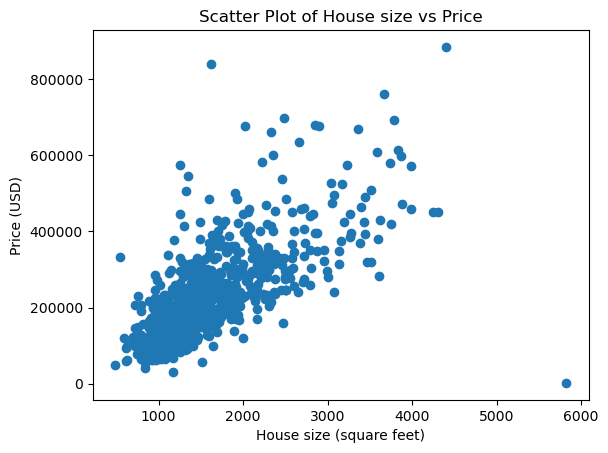

In [3]:
# Plot
plt.scatter(sacramento["sq__ft"], sacramento['price'])

# Add labels and legend
plt.xlabel("House size (square feet)")
plt.ylabel('Price (USD)')
plt.title('Scatter Plot of House size vs Price')
plt.show()

We can see that in Sacramento, CA, larger houses tend to have higher sale prices. This means we might be able to predict the sale price of a house we haven't sold yet based on its size. 

> **Note**:
> It's important to remember that we're not saying a bigger house **causes** a higher price; we're just observing that larger houses generally sell for more, so size can help us estimate the price.

### K-nearest neighbors regression

KNN regression is like K-Nearest Neighbors, but instead of predicting a category, it predicts a number. It looks at the closest `k` data points and then takes the average of their values to make the prediction. For example, if you want to predict a house price, KNN regression will look at the prices of the closest `k` houses and use their average as the predicted price.

Let's start with a small sample of the data to understand how K-nearest neighbors (KNN) works for regression. By using this small subset, we can illustrate the basics of KNN regression and how it predicts house sale prices before building and evaluating a full model.

To take a small random sample of size 30, we’ll use the `sample` method on the sacramento data frame, specifying that we want to select n=30 rows.

In [4]:
small_sacramento = sacramento.sample(n=30)

To estimate the sale price of a 2,000 square-foot house in Sacramento when we don't have exact data for that size, we can use KNN.

1. **Find Similar Houses**: Identify houses in the dataset that are closest in size to 2,000 square feet. This involves calculating the distance between the 2,000 square-foot house and the sizes of other houses in the dataset.

2. **Select Neighbors**: Choose a small number of these closest houses (the "neighbors"). The number of neighbors is a parameter you can set for KNN.

3. **Average Price**: Calculate the average sale price of these neighbors. This average will give you an estimate of the price for the 2,000 square-foot house.

By using this approach, you can make an informed offer based on the sale prices of similar houses in the dataset, even though you don’t have an exact match for the 2,000 square-foot size.

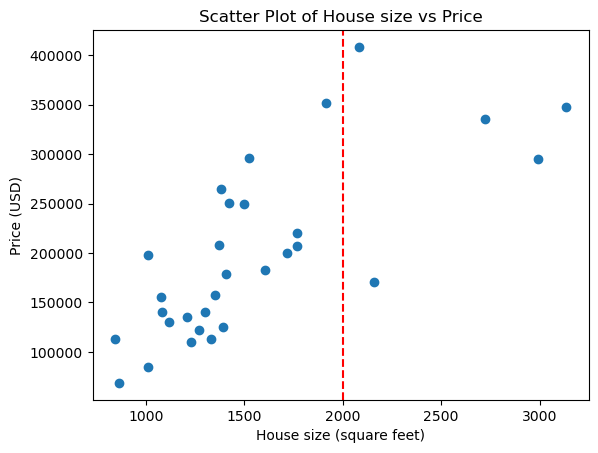

In [17]:
# Plot
plt.scatter(small_sacramento["sq__ft"], small_sacramento['price'])

# Add a vertical line at 2,000 square feet
plt.axvline(x=2000, color='red', linestyle='--', label='2000 sqft')

# Add labels and legend
plt.xlabel("House size (square feet)")
plt.ylabel('Price (USD)')
plt.title('Scatter Plot of House size vs Price')

plt.show()

We will employ the same idea as our prior notebooks, and use the neighboring points to the new point of interest to predict what its sale price might be. 

For the example here we find and label the 5 nearest neighbors to our observation of a house that is 2,000 square feet.

In [18]:
# Calculate the absolute difference between 2000 and the square footage of each house
small_sacramento["dist"] = (2000 - small_sacramento["sq__ft"]).abs()

# Find the 5 rows with the smallest distances (closest to 2000 square feet)
nearest_neighbors = small_sacramento.nsmallest(5, "dist")

# Display the 5 nearest neighbors
nearest_neighbors

,street,city,zip,state,beds,baths,sq__ft,type,sale_date,price,latitude,longitude,dist
250,3361 ALDER CANYON WAY,ANTELOPE,95843,CA,4,3,2085,Residential,Mon May 19 00:00:00 EDT 2008,408431,38.727649,-121.385656,85
318,4143 SEA MEADOW WAY,SACRAMENTO,95823,CA,4,3,1915,Residential,Wed May 21 00:00:00 EDT 2008,351300,38.465340,-121.457519,85
744,8884 AMBERJACK WAY,SACRAMENTO,95828,CA,3,2,2161,Residential,Fri May 16 00:00:00 EDT 2008,170250,38.479343,-121.372553,161
52,1178 WARMWOOD CT,GALT,95632,CA,4,2,1770,Residential,Thu May 15 00:00:00 EDT 2008,220000,38.289544,-121.284607,230
546,6671 FOXWOOD CT,SACRAMENTO,95841,CA,4,2,1766,Residential,Mon May 19 00:00:00 EDT 2008,207000,38.687943,-121.328883,234


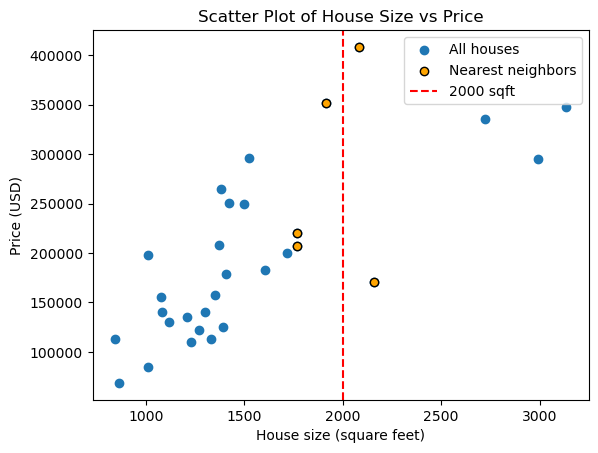

In [7]:
# Scatter plot
plt.scatter(small_sacramento["sq__ft"], small_sacramento['price'], label='All houses')

# Plot nearest neighbors in orange
plt.scatter(nearest_neighbors["sq__ft"], nearest_neighbors['price'], color='orange', label='Nearest neighbors', edgecolor='black')

# Add a vertical line at 2,000 square feet
plt.axvline(x=2000, color='red', linestyle='--', label='2000 sqft')

# Add labels, title, and legend
plt.xlabel("House size (square feet)")
plt.ylabel('Price (USD)')
plt.title('Scatter Plot of House Size vs Price')
plt.legend()

We can then take the mean (or average) of these 5 values as our predicted value,

In [8]:
prediction = nearest_neighbors["price"].mean()
prediction

271396.2

Similar to KNN classification, we have some remaining steps. which $K$ do we choose, and is our model any good at making predictions?

### Training, evaluating, and tuning the model

Step 1. Split the dataset into test and train

In [9]:
sacramento_train, sacramento_test = train_test_split(
    sacramento, train_size=0.75
)

Step 2. Cross-validation

In KNN regression, to evaluate how well the model predicts the response variable, we use root mean square prediction error (RMSPE). The formula for calculating RMSPE is:

$$
 \text{RMSPE} = \sqrt{\frac{1}{n} \sum_{i=1}^n \left( \frac{y_i - \hat{y}_i}{y_i} \right)^2} 
 $$

where:
- $ y_i $ is the true value of the response variable,
- $ \hat{y}_i $ is the predicted value from the model,
- $ n $ is the number of observations.

RMSPE measures how much our predictions deviate from the actual values. It gives us an idea of how close our predictions are to the real outcomes, with a focus on errors relative to the size of the values we're predicting.

Here is the above mathematical notation in python:

In [ ]:
import math

def rmspe(y_true, y_pred):
    """
    Calculate Root Mean Squared Percentage Error (RMSPE)
    
    Parameters:
    y_true: list-like, actual values
    y_pred: list-like, predicted values
    
    Returns:
    float: RMSPE value
    """
    n = len(y_true)
    squared_percentage_errors = []

    # Calculate the squared percentage errors using a loop
    for i in range(n):
        percentage_error = (y_true[i] - y_pred[i]) / y_true[i]
        squared_percentage_errors.append(percentage_error ** 2)

    # Calculate the mean of squared percentage errors
    mean_squared_error = sum(squared_percentage_errors) / n

    # Calculate the square root of the mean squared percentage error
    rmspe_value = math.sqrt(mean_squared_error)
    
    return rmspe_value

### Let's Begin KNN Regressor Training:

Let's see if there is any correlation between square footage and price.

In [19]:
# Step 1: Split training data into X (predictor) and Y (response)
X_train = sacramento_train[["sq__ft"]]
y_train = sacramento_train["price"]

# Step 2: Initialize K-NN regressor
knn_regressor = KNeighborsRegressor()

# Step 3: Define parameter grid for GridSearchCV
param_grid = {
    "n_neighbors": range(1, 201, 3),        # But wait...? What is this?
}

# Step 4: Initialize and fit GridSearchCV
sacr_gridsearch = GridSearchCV(
    estimator=knn_regressor,
    param_grid=param_grid,
    cv=5,
    scoring="neg_root_mean_squared_error"
)

sacr_gridsearch.fit(X_train, y_train)

# Step 5: Retrieve and format results
results = pd.DataFrame(sacr_gridsearch.cv_results_)     # After fitting the model, we extract the cross-validation results using `cv_results_`. This output includes various metrics and parameters tested during the cross-validation process.
results["sem_test_score"] = results["std_test_score"] / 5**(1/2)
results = (
    results[[
        "param_n_neighbors",
        "mean_test_score",
        "sem_test_score"
    ]]
    .rename(columns={"param_n_neighbors": "n_neighbors"})
) # we specify the scoring metric as "neg_root_mean_squared_error" to evaluate the model performance based on RMSPE.

print(results)

   n_neighbors  mean_test_score  sem_test_score
0            1   -121337.297909     4117.083515
1            4    -94944.752321     4171.713843
2            7    -91758.021360     5126.656895
3           10    -89685.688053     4831.300115
4           13    -87916.272482     4987.376215
..         ...              ...             ...
62         187    -93232.658157     6075.005187
63         190    -93439.409277     6075.793281
64         193    -93623.687371     6091.234720
65         196    -93854.604300     6106.334080
66         199    -94099.813635     6103.823449

[67 rows x 3 columns]


>
> ##### But Wait...?
>
> *"Why are they using 1-200? How do they know 200 is enough?"*
>   - They don't! That's just an intuition, they could've done 20. They are testing values from 1 to 200 because different datasets and problems might require different optimal values for n_neighbors.
>
> *"Well why are they checking every 3 steps? Why not all of them?"*
>   - The step size of 3 is used to reduce the number of computations, ensuring a balance between exploring a wide range of values and not taking too long by testing every possible value between 1 and 200.
>

Next, we can run cross-validation by calling the fit method on our GridSearchCV object (sacr_gridsearch).

>
> #### Note:
>
> The use of double brackets sacramento_train[["sqft"]] to ensure the input features are in a DataFrame format. 
> This is important because scikit-learn often works better with DataFrames rather than Series for input features. 
>
 
For the response variable, a Series format (sacramento_train["price"]) is acceptable. 🚩why?🚩

Lastly, we extract relevant columns (e.g., mean test scores and parameter values) and compute the standard error of the mean test score, based on the 5-fold cross-validation.

In [11]:
# fit the GridSearchCV object
sacr_gridsearch.fit(
    sacramento_train[["sq__ft"]],  # A single-column data frame
    sacramento_train["price"]  # A series
)

# Retrieve the CV scores
sacr_results = pd.DataFrame(sacr_gridsearch.cv_results_)

# Retrieve the CV scores
sacr_results = pd.DataFrame(sacr_gridsearch.cv_results_)
sacr_results["sem_test_score"] = sacr_results["std_test_score"] / 5**(1/2)
sacr_results = (
    sacr_results[[
        "param_n_neighbors",
        "mean_test_score",
        "sem_test_score"
    ]]
)
sacr_results

,param_n_neighbors,mean_test_score,sem_test_score
0,1,-121337.297909,4117.083515
1,4,-94944.752321,4171.713843
2,7,-91758.021360,5126.656895
3,10,-89685.688053,4831.300115
4,13,-87916.272482,4987.376215
...,...,...,...
62,187,-93232.658157,6075.005187
63,190,-93439.409277,6075.793281
64,193,-93623.687371,6091.234720
65,196,-93854.604300,6106.334080


In the `sacr_results` DataFrame, the `n_neighbors` column shows the values of `n_neighbors`, and the `mean_test_score` column displays the RMSPE values estimated via cross-validation. However, RMSPE is always be nonnegative because it measures **how far off the model’s predictions are from the actual values**—the difference, like a distance, can’t be negative.

Scikit-learn was built to always try to **maximize** scores. Since RMSE is a metric where **lower is better**, it automatically flips it to a negative value (that’s why there’s a `"neg_"` prefix). This lets Scikit-learn treat it like a score to maximize, even though we are really trying to minimize the error. To get the actual RMSPE values, we need to convert these negative values back to positive by taking their absolute values.

In [12]:
sacr_results["mean_test_score"] = -sacr_results["mean_test_score"]
sacr_results

,param_n_neighbors,mean_test_score,sem_test_score
0,1,121337.297909,4117.083515
1,4,94944.752321,4171.713843
2,7,91758.021360,5126.656895
3,10,89685.688053,4831.300115
4,13,87916.272482,4987.376215
...,...,...,...
62,187,93232.658157,6075.005187
63,190,93439.409277,6075.793281
64,193,93623.687371,6091.234720
65,196,93854.604300,6106.334080


In the `sacr_results` DataFrame, the `mean_test_score` now correctly reflects the RMSPE values for different numbers of neighbors. The `sem_test_score` represents the standard error of these RMSPE estimates, giving us an idea of how precise our RMSPE estimates are. 

##### For example: 
If the mean RMSPE is $100,000 with a standard error of $1,000, the true RMSPE is likely between $99,000 and $101,000, though it could be outside this range. 

#### This means that our model’s house price predictions are off by about $99,000 to $101,000.



We can visualize how RMSPE changes with different numbers of neighbors. By finding the minimum RMSPE, we can determine the best number of neighbors for our model. In this case, the lowest RMSPE occurs when the number of neighbors is 58.

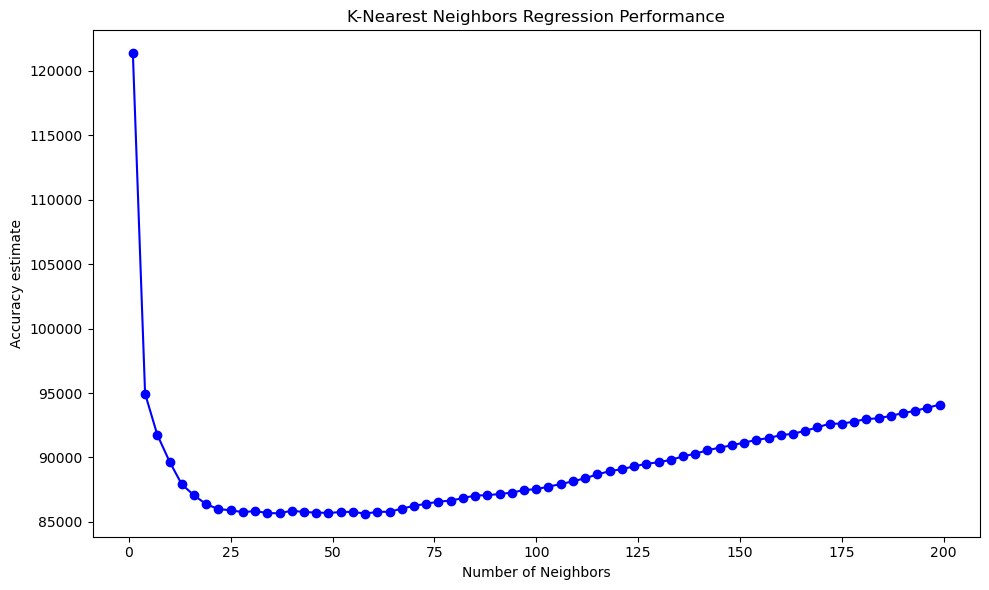

In [13]:
# Create the plot
plt.figure(figsize=(10, 6))

# Plot mean test scores with error bars
plt.plot(sacr_results['param_n_neighbors'], sacr_results['mean_test_score'], '-o', color='blue')

# Add labels and legend
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy estimate')
plt.title('K-Nearest Neighbors Regression Performance')
plt.tight_layout()
plt.show()

In [14]:
sacr_gridsearch.best_params_

{'n_neighbors': 58}

### Model Evaluation

To evaluate how well our model predicts unseen data, we'll check its RMSPE on the test set. First, we need to retrain the K-NN regression model using 58 neighbors on the full training data. Scikit-learn handles this automatically when using `GridSearchCV`. To make predictions, we use the `predict` method from the fitted `GridSearchCV` object. We then calculate the RMSPE by computing the mean squared error with `mean_squared_error` and taking the square root. We use this method instead of the `score` method because `KNeighborsRegressor` uses a different default metric than RMSPE.

In [15]:
# Make predictions on the test set
sacramento_test["predicted"] = sacr_gridsearch.predict(sacramento_test[["sq__ft"]])

# Calculate RMSPE
rmspe = mean_squared_error(
    y_true=sacramento_test["price"],
    y_pred=sacramento_test["predicted"]
)**0.5

rmspe

82063.9889000861

Our final model’s test error as assessed by RMSPE is $82,063.

> **Note:**
>
> The RMSPE is in the same units as the response variable, so for new observations, we expect prediction errors to be around $82,063. In this case, it’s not negligible and could significantly impact a home buyer's budget, influencing their decision to make an offer on a house.

We can visualize the predictions of our final model across various house sizes in Sacramento. 

We can overlay a prediction line on a scatter plot of the original housing price data to qualitatively assess how well the model fits the data. 

/Users/Dan/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


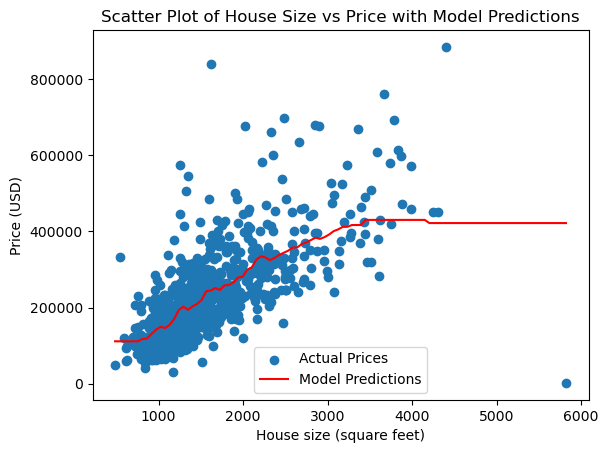

In [16]:
# Generate a range of house sizes for prediction
sizes = np.linspace(sacramento["sq__ft"].min(), sacramento["sq__ft"].max(), 100).reshape(-1, 1)

# Predict house prices for these sizes using the best model from GridSearchCV
predicted_prices = sacr_gridsearch.predict(sizes)

# Plot the original data
plt.scatter(sacramento["sq__ft"], sacramento["price"], label="Actual Prices")

# Plot the model predictions as a line
plt.plot(sizes, predicted_prices, color='red', label="Model Predictions")

# Add labels and legend
plt.xlabel("House size (square feet)")
plt.ylabel("Price (USD)")
plt.title("Scatter Plot of House Size vs Price with Model Predictions")
plt.legend()
plt.show()


Don't worry about the details of this plot. This is simply depicting the predicted values of house price (red line) for the final KNN regression model.



### Conclusion

In this notebook, we worked through several steps to predict housing prices using square feet using a data set of 932 real estate transactions in Sacramento, California. Here's a summary of what we covered:

1. **K-Nearest Neighbors Regression (KNN):** We implemented the KNN regression and evaluated its performance on a test dataset.

2. **Cross-Validation:** We used cross-validation to determine the optimal $k$ value for our model.


We hope this notebook has provided a practical understanding of data regression, model evaluation, and the application of machine learning algorithms like KNN. Feel free to experiment further with the dataset or the code to enhance your learning!